In [1]:
library(readxl) 
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(rvest)
set.seed(3000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Predicting the Student Knowledge Levels for Electrical DC Machines 

## Introduction

### Background

A user knowledge model is a representation of the conceptual understanding of a user. It is used around the world, and the main goal is to customize systems to adapt the needs of the user. In the past, computers have provided specific information to humans, but nowadays, they are more expected to understand the habits of users and be able to present them with information that is useful to them. Some examples of usages include intelligent tutoring systems, which help students in a specific field of study, and recommender systems, which are used to present products to users that fit their needs.

### Our Question

**Can we predict a user’s level of knowledge solely based on exam scores?**

### Our Dataset

We are using the User Knowledge dataset, where students are tested about the subject of Electrical DC Machines. In this dataset, we are provided with various statistics. Each row in the dataset represents a user, and each column represents various statistics on the user. The 6th column is the knowledge level of the user, which is what we are trying to predict. Columns 1-5 are possible predictors for the user knowledge level. 

These possible predictors are: the degree of study time for goal object materials (STG), the degree of repetition number of the user for goal object materials (SCG), the degree of study time for related objects with goal object (STR), the exam performance of the user for related objects with goal object (LPR), and the exam performance of the user for goal object materials (PEG). Essentially, the possible predictors are either how much an individual has studied, repeated, or how well they did on the exam. We will further explore these possible predictors to figure out which ones to use to predict the user knowledge level.

We do not need to process this dataset, because it is already tidy. Variables are in columns, observations are in rows, and each value has its own cell. The data is also already split into training and testing data for us, and has been scaled as well. 



## Methods and Results

### Outline

We will start by loading and wrangling our data into a form with our potential predictors and predictor class, UNS (Student Knowledge Level). Then we will find and isolate the predictors most relevant to predicting UNS. As this is a classification problem, we will be using the K nearest neighbors method which means we will be performing cross-validation to find the optimal K value to use. Lastly we will take certain new data with predicted outcomes and pass them through our model to see if it can sucessfully predict a knowledge level of a new student.

### Exploring the Data

**The code below downloads the data from the URL**

In [25]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi.xls")

**The data has aready been split in the training and testing data for us by the gatherer, therefore the next two codes load the training, then testing data respectively and mutates our class, UNS, into a factor. The data is already tidy, however, the factor name used for the testing data is "Very Low" while the triaining data is simply "very_low" so have to also rename the factor level for the testing data.**

In [26]:
training_data <- read_excel("Data_User_Modeling_Dataset_Hamdi.xls", sheet = 2) %>%
select(STG:UNS) %>%
mutate(UNS = as.factor(UNS)) 
head(training_data, n = 10) 

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


Table 1: Training Data

In [27]:
testing_data <- read_excel("Data_User_Modeling_Dataset_Hamdi.xls", sheet = 3) %>%
select(STG:UNS)

testing_data[testing_data == "Very Low"] <- "very_low"

testing_data <- testing_data %>%
mutate(UNS = as.factor(UNS))

head(testing_data, n = 10)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low
0.16,0.16,0.80,0.50,0.50,Middle
0.12,0.12,0.75,0.68,0.15,Low
0.20,0.20,0.88,0.77,0.80,High


Table 2: Testing data

**The table below shows the counts for each of our 4 classes of our training data. The results show that there are quite a few observations for middle and low compared to High, and very_low which suggests that we will have to balance our data in our recipe step.**

In [28]:
UNS_counts <- group_by(training_data, UNS) %>%
summarize(n = n()) %>%
arrange(desc(n))
UNS_counts

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
Middle,88
Low,83
High,63
very_low,24


Table 3: Counts for each User Knowledge Data of our training data

In [29]:
set.seed(3000)
UNS_recipe_balanced <- recipe(UNS ~., data = training_data) %>%
step_upsample(UNS, over_ratio = 1, skip = FALSE) %>% 
prep()

balanced_training_data <- bake(UNS_recipe_balanced, training_data)


balanced_training_data_count <- balanced_training_data %>%
group_by( UNS) %>%
summarize(n = n())
balanced_training_data_count



`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
High,88
Low,88
Middle,88
very_low,88


Table 4: Counts for each User Knowledge Data after balancing

**To get a general sense of which predictors we should use, we made a table of plots using [ggpairs] and to which we can see that many of our predictors such as STG, SCG, and STR lack any sort of solid relationship with the UNS. We can also see that PEG is a fairly good predictor and that PEG with LPR seems to be a favourable combination of predictors to use.**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



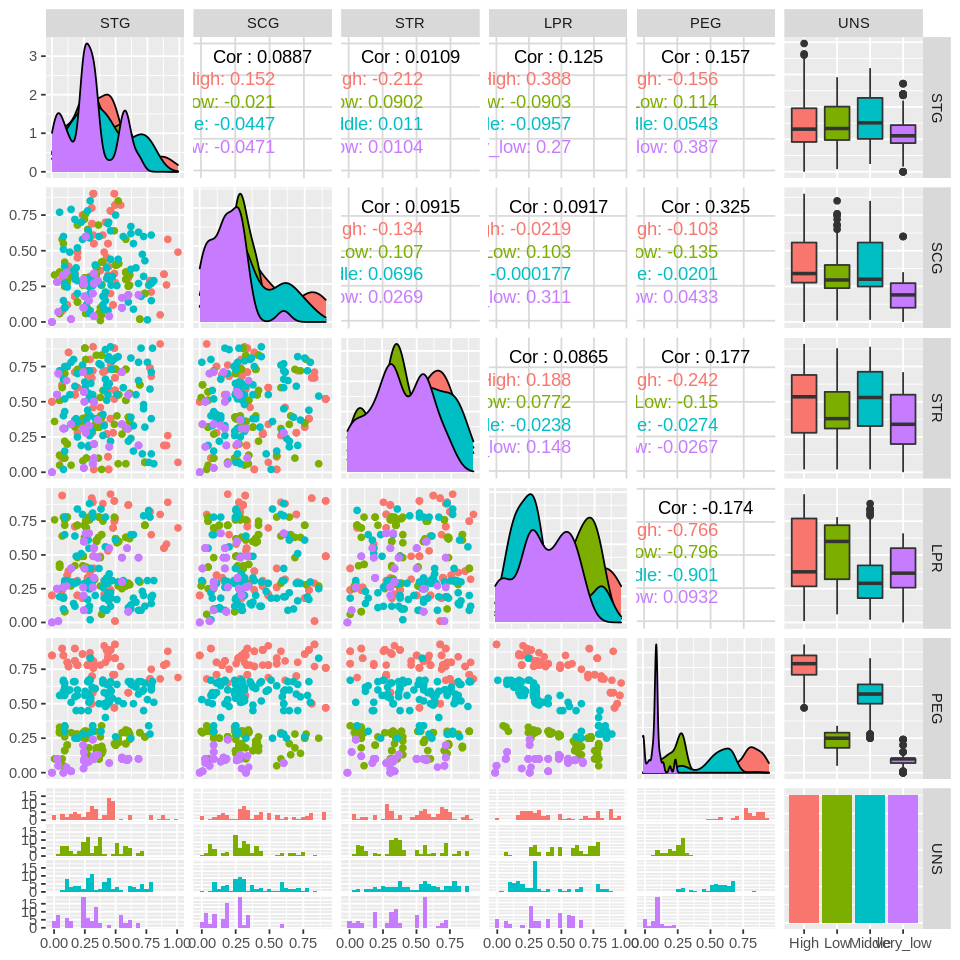

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8)
graph <- balanced_training_data %>%
    ggpairs(aes(color = UNS))

graph

Figure 1: A plot of all of our potential predictors coloured by class

**We isolated our best predictors to better show a relationship between the Knowledge level and PEG and LPR. Both PEG and LPR seem to have a positive, linear relationship with UNS.**


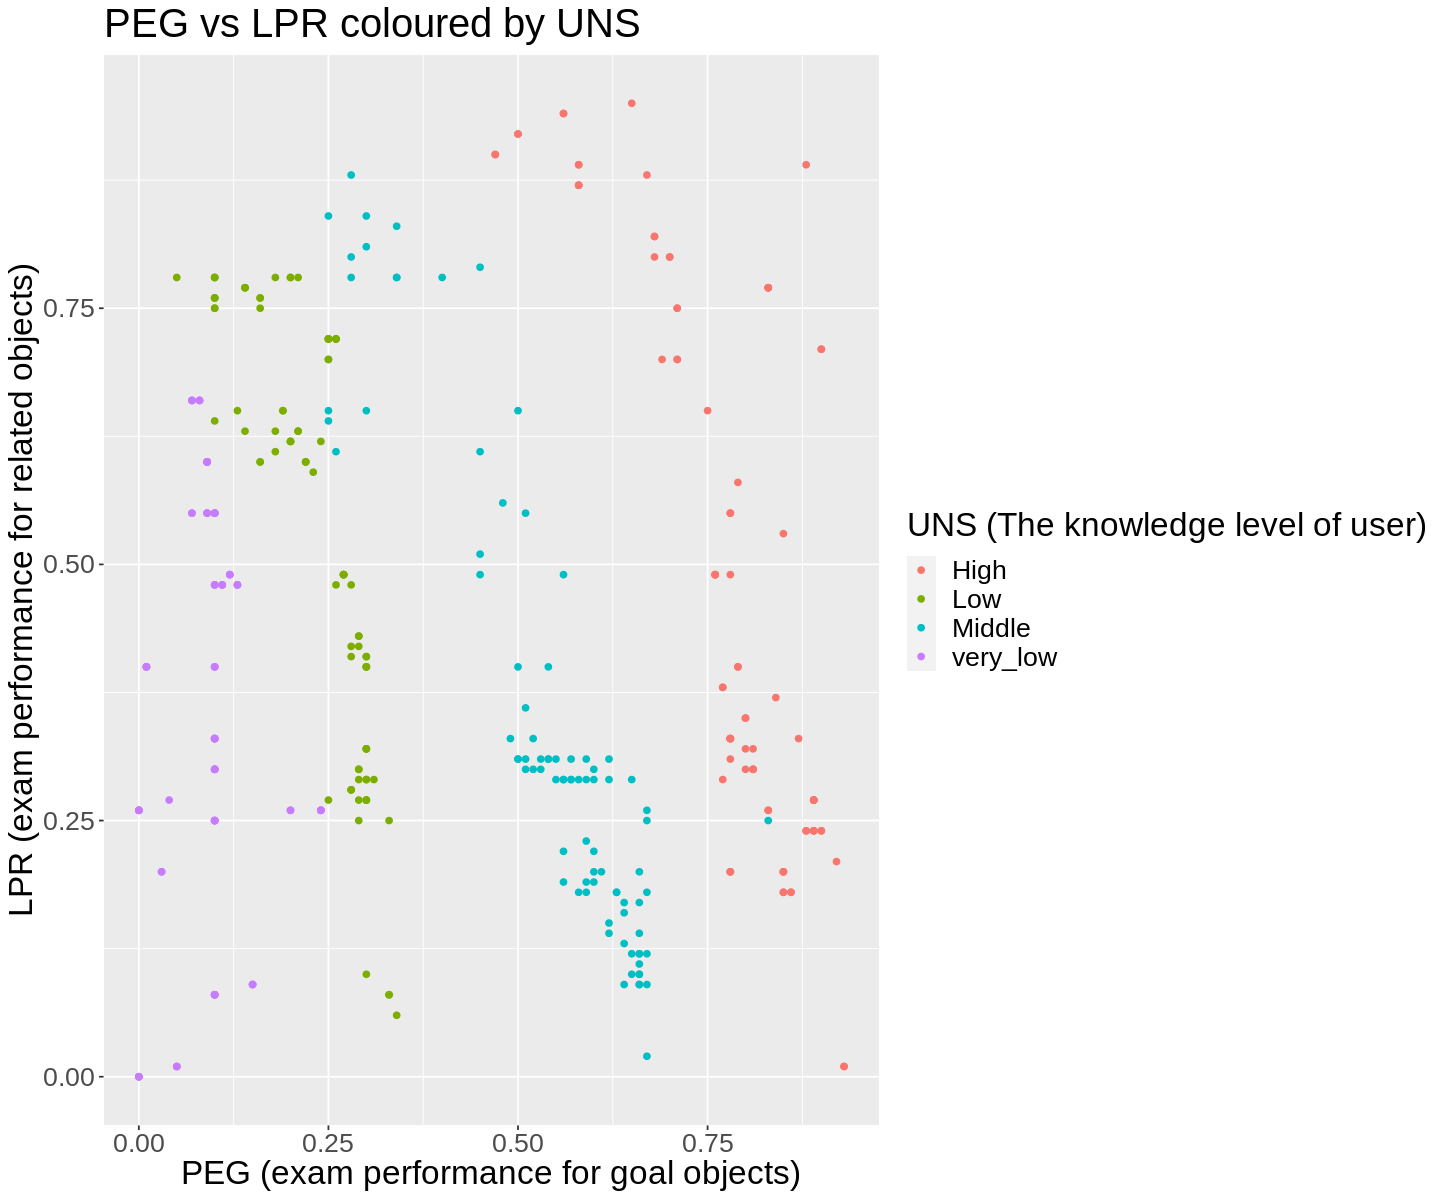

In [31]:
options(repr.plot.width = 12, repr.plot.height = 10)
predictor_plot <- ggplot(balanced_training_data, aes(x = PEG, y = LPR, color = UNS)) +
geom_point() +
labs(x = "PEG (exam performance for goal objects)", y = "LPR (exam performance for related objects)", color = "UNS (The knowledge level of user)") +
ggtitle("PEG vs LPR coloured by UNS") +
theme(text = element_text(size = 20))
predictor_plot

Figure 2: A plot of or predictors coloured by class

**To show that PEG and LPR are our best predictors in terms of coding we used forward selection to compare the accuracy of each string of predictors and identified that PEG + LPR is indeed our ideal combination for training and evaluating our data with. As you can see from Table 4, adding or taking away a predictor lowers the estimated accuracy.**

In [32]:
set.seed(3000)
UNS_subset <- balanced_training_data  %>%
select(STG, SCG, STR, LPR, PEG, UNS)

names <- colnames(UNS_subset %>% select(- UNS))



accuracies <- tibble(size = integer(),
                    model_string = character(),
                     accuracy = numeric())

knn_spec <- nearest_neighbor("weight_func" = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

UNS_vfold <- vfold_cv(UNS_subset, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:length(names)) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(names, collapse = "+"))
        
UNS_recipe <- recipe(as.formula(model_string), data = UNS_subset) 
        
acc <- workflow() %>%
add_recipe(UNS_recipe) %>%
add_model(knn_spec) %>%
tune_grid(resamples = UNS_vfold, grid = 10) %>% 
collect_metrics()  %>%
filter(.metric == "accuracy") %>%
summarize(mx = max(mean))
        
acc <- acc$mx %>% unlist()
        
accs[[j]] <- acc
models[[j]] <- model_string 
    }
    
jstar <- which.max(unlist(accs))
accuracies <- accuracies %>%
add_row(size = i, model_string = models[[jstar]],
accuracy = accs[[jstar]])
    
selected <- c(selected, names[[jstar]])
names <- names[-jstar]
    }

accuracies              

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ STG+SCG+STR+LPR+PEG,0.9065359
2,UNS ~ SCG+STR+LPR+PEG,0.9235294
3,UNS ~ STR+LPR+PEG,0.9516340
4,UNS ~ LPR+PEG,0.9854575
5,UNS ~ PEG,0.8031046


Table 5: Predictors and their estimated Accuracies

**Using a 5-fold cross validation we tested neighbors (k) from 1 to 12 and then charted and graphed their estimated accuracies. Looking at the plot we concluded that 3-6 neighbors is the optimal k value since they're all quite accurate according to our model evaluation. We ended up choosing 5 as it's in the middle of that range which means adding or taking away a neighbor would not change the estimated accuracy too much.** 

In [33]:
set.seed(3000)

UNS_recipe_k <- recipe(UNS ~ PEG + LPR, data = balanced_training_data)

k_vals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))


UNS_results_k <- workflow() %>%
add_recipe(UNS_recipe_k) %>%
add_model(knn_spec) %>%
tune_grid(resamples = UNS_vfold, grid = k_vals) %>%
collect_metrics() %>%
filter(.metric == "accuracy")
UNS_results_k


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9854575,5,0.008056401,Model01
2,accuracy,multiclass,0.9854575,5,0.008056401,Model02
3,accuracy,multiclass,0.9854575,5,0.008056401,Model03
4,accuracy,multiclass,0.9854575,5,0.008056401,Model04
5,accuracy,multiclass,0.9799020,5,0.010965988,Model05
6,accuracy,multiclass,0.9799020,5,0.010965988,Model06
7,accuracy,multiclass,0.9661765,5,0.014379085,Model07
8,accuracy,multiclass,0.9661765,5,0.014379085,Model08
9,accuracy,multiclass,0.9575163,5,0.016210682,Model09


Table 6: Estimated accuracies for each K value 1 to 12

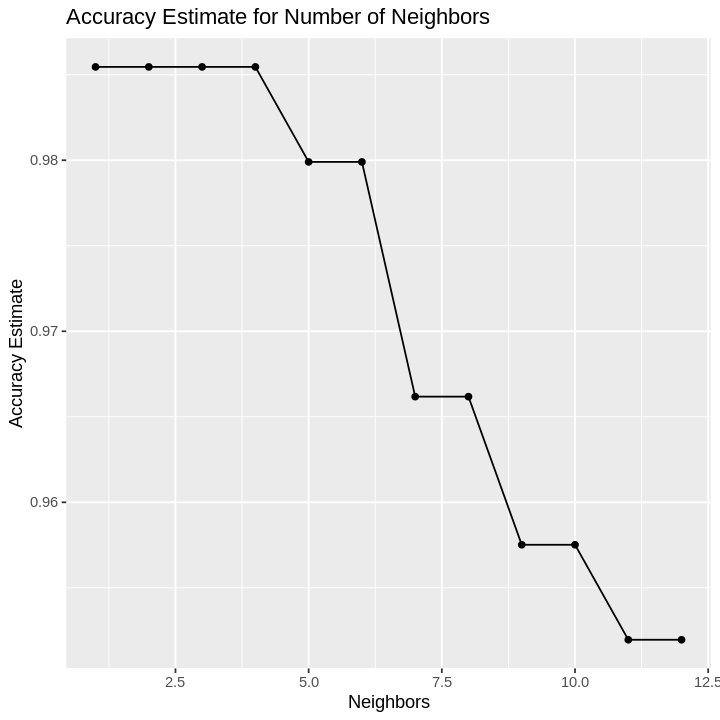

In [34]:

options(repr.plot.width=6, repr.plot.height=6)
accuracy_versus_k <- ggplot(UNS_results_k, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Accuracy Estimate for Number of Neighbors")
accuracy_versus_k

Figure 3: Line plot of neighbors with their estimated accuracies

**Using 5 nearest neighbors, we then predict the knowledge levels of our testing data and estimated the accuracy which is 93.7931%. This should be a good enough estimate for our purposes of predicting the general knowledge levels of students.**


In [35]:
set.seed(3000)
knn_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
set_engine("kknn") %>%
set_mode("classification")

UNS_fit <- workflow() %>%
add_model(knn_spec_test) %>%
add_recipe(UNS_recipe_k) %>%
fit(data = balanced_training_data)

UNS_test <- predict(UNS_fit, testing_data) %>%
bind_cols(testing_data) %>%
metrics(truth = UNS, estimate = .pred_class) %>%
filter(.metric == "accuracy")

UNS_test



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.937931


Table 7: The estimated accuracy of our model

**Since LPR and PEG are measured on the same scale and appear to have the same relationship to knowledge level, we will use the data, 0.1, 0.3, 0.6, and 0.9 for both predictors to represent very low, low, middle, and high knowledge levels respectively.**

**As a result you can see that our labeled knowledge levels for these new students match the estimated knowledge level our K-nearest neighbor model predicted for them.**

In [36]:
set.seed(3000)
new_students <- tibble(name = c("very low student", "low student", "middle student", "High Student"),
                      LPR = c(0.1, 0.3, 0.6, 0.9),
                      PEG = c(0.1, 0.3, 0.6, 0.9))

prediction <- predict(UNS_fit, new_students) %>%
bind_cols(new_students) %>%
rename(UNS = .pred_class)

prediction

UNS,name,LPR,PEG
<fct>,<chr>,<dbl>,<dbl>
very_low,very low student,0.1,0.1
Low,low student,0.3,0.3
Middle,middle student,0.6,0.6
High,High Student,0.9,0.9


Table 8: New students analysis

## Discussion

Overall, we found that students’ LPR and PEG are enough and good predictors to predict their knowledge level. Using these predictors, we found k = 5 through 5-fold cross-validation and then we trained a KNN-classification model with 0.937931 accuracy which is good enough to estimate the UNS. We tested our model on some newly created students, with LPR and a PEG, and we found that the predicted UNS reflected the stats accordingly.

The result makes sense, the knowledge level is solely based on exam scores. Both PEG and LPR seem to have a positive, linear relationship with UNS. Also, in our test students, the outcome was approximately what we would expect. If the student had good LPR and PEG, their predicted knowledge level would be higher, and vice versa for a student with bad LPR and PEG.

Our finding is very useful. On the one hand, we confirmed the usefulness of exams. It is good for schools to have exams to test the knowledge of the level of students. On the other hand, students can focus on their performance of exams and increase their knowledge of level through having many practice exams.

### Further questions 

1. Are there variables not included in the dataset that could improve the effectiveness of the model?
2. Since there is a kind of people who has mental stress during the exam which can affect the performance, according to these people, can we get the same findings as above?

## References

Makhfi, P. (n.d.). Introduction to Knowledge Modeling. Introduction to knowledge modeling. Retrieved December 4, 2021, from http://www.makhfi.com/KCM_intro.htm.

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2012, August 21). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems. Retrieved December 4, 2021, from 
https://www.sciencedirect.com/science/article/abs/pii/S0950705112002225.

### Dataset:
UCI Machine Learning Repository: User knowledge modeling data set. (n.d.). Retrieved December 4, 2021, from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#.
